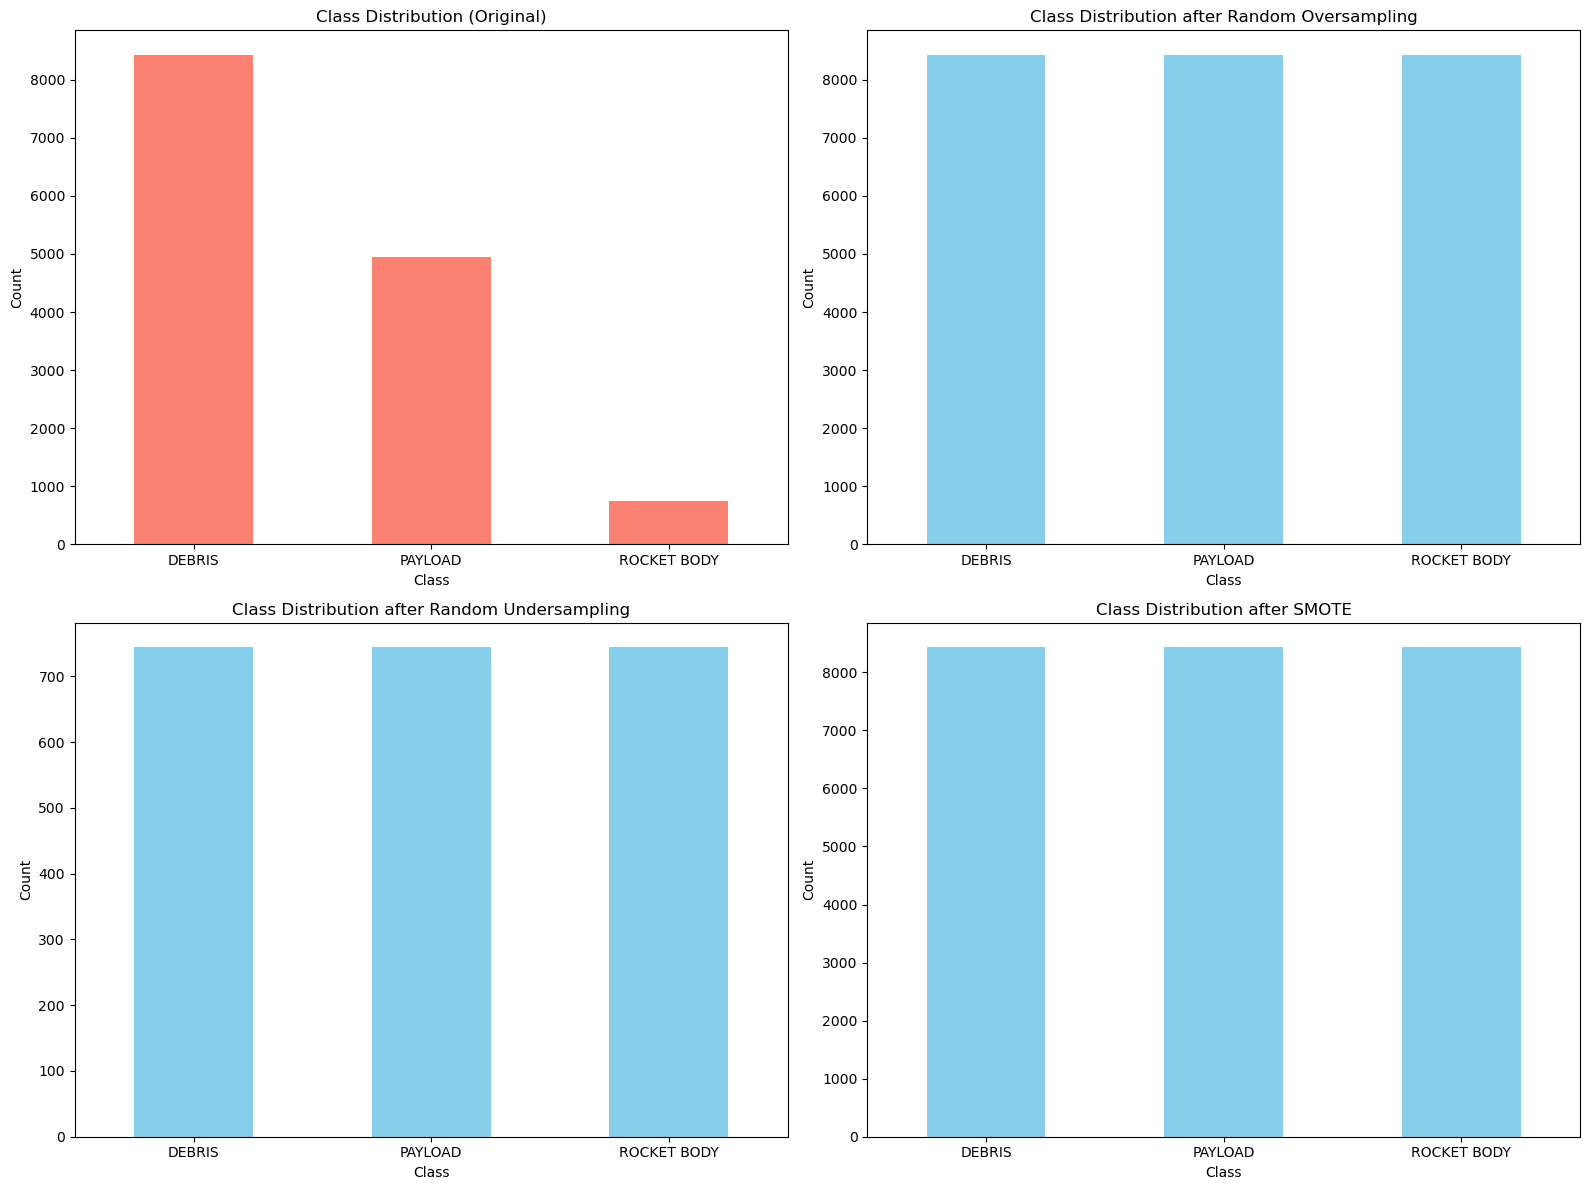


Feature selection using Mutual Information

Results for Random Oversampling and feature selection by Mutual Information:

Model: KNN
Precision: 0.9312146277753591
Recall: 0.839811542991755
F1-score: 0.8831544178364987

Model: Decision Tree
Precision: 0.9854958839670718
Recall: 0.9870435806831567
F1-score: 0.9862691251471165

Model: Random Forest
Precision: 0.9902037617554859
Recall: 0.9921476246564586
F1-score: 0.9911747401451265

Model: SVM
Precision: 0.6792992491955667
Recall: 0.745975657636435
F1-score: 0.7110778443113772

Results for Random Undersampling and feature selection by Mutual Information:

Model: KNN
Precision: 0.6903765690376569
Recall: 0.7603686635944701
F1-score: 0.7236842105263158

Model: Decision Tree
Precision: 0.9023255813953488
Recall: 0.8940092165898618
F1-score: 0.8981481481481481

Model: Random Forest
Precision: 0.920704845814978
Recall: 0.9631336405529954
F1-score: 0.9414414414414415

Model: SVM
Precision: 0.6564885496183206
Recall: 0.7926267281105991
F1-scor

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from itertools import cycle
from sklearn.preprocessing import label_binarize

# Load the dataset
data = pd.read_csv('Space_data1.csv')

# Handle missing values
data["RCS_SIZE"] = data["RCS_SIZE"].fillna("Unknown")

# Remove rows where OBJECT_TYPE is 'TBA'
data = data[data['OBJECT_TYPE'] != 'TBA']

# Label encoding for categorical variables
label_encoders = {}
categorical_columns = ['OBJECT_TYPE', 'RCS_SIZE', 'COUNTRY_CODE', 'SITE', 'FILE']
for column in categorical_columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Scaling numerical features
scaler = StandardScaler()
numerical_columns = ['MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION', 'RA_OF_ASC_NODE', 'ARG_OF_PERICENTER',
                     'MEAN_ANOMALY', 'BSTAR', 'SEMIMAJOR_AXIS', 'PERIOD', 'APOAPSIS', 'PERIAPSIS']
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# Convert 'EPOCH' and 'LAUNCH_DATE' to Unix timestamps
data['EPOCH'] = pd.to_datetime(data['EPOCH'])
data['LAUNCH_DATE'] = pd.to_datetime(data['LAUNCH_DATE'], format='%Y')
data['EPOCH_TIMESTAMP'] = data['EPOCH'].astype('int64') // 10**9
data['LAUNCH_DATE_TIMESTAMP'] = data['LAUNCH_DATE'].astype('int64') // 10**9
data = data.drop(columns=['EPOCH', 'LAUNCH_DATE'])

# Set 'OBJECT_TYPE' as the target variable
X = data.drop(columns=['OBJECT_TYPE'])
y = data['OBJECT_TYPE']

# Mutual Information, Chi-square, F-test for feature selection
mutual_info = mutual_info_classif(X, y)
mi_scores = pd.Series(mutual_info, index=X.columns).sort_values(ascending=False)
chi2_scores, _ = chi2(X.abs(), y)
chi2_scores_series = pd.Series(chi2_scores, index=X.columns).sort_values(ascending=False)
f_scores, _ = f_classif(X, y)
f_scores_series = pd.Series(f_scores, index=X.columns).sort_values(ascending=False)

# Selected top 10 features for each method
top_features_mi = mi_scores.head(10).index
top_features_chi2 = chi2_scores_series.head(10).index
top_features_f_test = f_scores_series.head(10).index

# Define feature selection methods
selection_methods = {
    'Mutual Information': top_features_mi,
    'Chi-Square': top_features_chi2,
    'F-Test': top_features_f_test
}

# Label mapping
label_mapping = {0: 'DEBRIS', 1: 'PAYLOAD', 2: 'ROCKET BODY'}

# Function to apply class balancing techniques
def apply_class_balancing(X, y, technique):
    if technique == 'Random Oversampling':
        ros = RandomOverSampler(random_state=42)
        return ros.fit_resample(X, y)
    elif technique == 'Random Undersampling':
        rus = RandomUnderSampler(random_state=42)
        return rus.fit_resample(X, y)
    elif technique == 'SMOTE':
        smote = SMOTE(random_state=42)
        return smote.fit_resample(X, y)
    else:
        raise ValueError("Unknown technique")

# Apply class balancing techniques
techniques = ['Random Oversampling', 'Random Undersampling', 'SMOTE']
balanced_data = {}

for technique in techniques:
    X_bal, y_bal = apply_class_balancing(X, y, technique)
    balanced_data[technique] = (X_bal, y_bal)

# Plotting class distribution before and after balancing
def plot_class_distribution(X, y, balanced_data, filename='class_distribution.png'):
    plt.figure(figsize=(16, 12))
    
    # Plot original class distribution
    plt.subplot(2, 2, 1)
    original_counts = pd.Series(y).map(label_mapping).value_counts()
    original_counts.plot(kind='bar', color='salmon')
    plt.title('Class Distribution (Original)')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    
    # Plot balanced class distributions
    for i, (technique, (X_bal, y_bal)) in enumerate(balanced_data.items(), start=2):
        plt.subplot(2, 2, i)
        balanced_counts = pd.Series(y_bal).map(label_mapping).value_counts()
        balanced_counts.plot(kind='bar', color='skyblue')
        plt.title(f'Class Distribution after {technique}')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.xticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig(filename)  # Save the plot as a PNG file
    plt.show()

plot_class_distribution(X, y, balanced_data)

# Set a threshold for selecting relevant ROC curves
f1_threshold = 0.95  # Adjust this based on your needs

# Train, evaluate models and plot ROC curves
def train_and_evaluate(X_train, y_train, X_test, y_test, selected_features, balancing_technique, selection_method):
    models = {
        'KNN': KNeighborsClassifier(),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'SVM': SVC(probability=True)  # Enable probability=True for ROC curve in SVM
    }

    results = {}
    n_classes = len(np.unique(y_train))
    y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
    
    colors = cycle(['blue', 'green', 'red', 'orange'])
    
    for i, (name, model) in enumerate(models.items()):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Calculate classification report
        report = classification_report(y_test, y_pred, output_dict=True)
        results[name] = report
        
        # Only proceed to plot ROC curves for the best performing models
        f1_score = report['1']['f1-score']  # Change '1' based on the positive class index
        
        if f1_score >= f1_threshold:
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test)
            else:
                y_proba = model.decision_function(X_test)
            
            # Calculate ROC curve and ROC-AUC for each class
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            plt.figure(figsize=(8, 6))  # Create a new figure for each model
            
            for j in range(n_classes):
                fpr[j], tpr[j], _ = roc_curve(y_test_binarized[:, j], y_proba[:, j])
                roc_auc[j] = auc(fpr[j], tpr[j])

            # Plot ROC curves
            for j, color in zip(range(n_classes), colors):
                plt.plot(fpr[j], tpr[j], color=color, lw=2,
                         label=f'Class {j} (area = {roc_auc[j]:.2f})')
            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve: {name} ({balancing_technique}, {selection_method})')
            plt.legend(loc="lower right")
            
            plt.savefig(f'roc_curve_{name}_{balancing_technique}_{selection_method}.png')  # Save ROC plot as a PNG
            plt.close()  # Close the figure to free up memory
    
    return results

# Evaluate models for each feature selection method and class balancing technique
for selection_name, selected_features in selection_methods.items():
    X_selected = X[selected_features]
    
    print(f"\nFeature selection using {selection_name}")
    
    for technique in techniques:
        X_bal, y_bal = balanced_data[technique]
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.3, random_state=42)
        
        # Train and evaluate models and plot ROC curves
        print(f"\nResults for {technique} and feature selection by {selection_name}:")
        results = train_and_evaluate(X_train, y_train, X_test, y_test, selected_features, technique, selection_name)
        
        for model_name, report in results.items():
            print(f"\nModel: {model_name}")
            print(f"Precision: {report['1']['precision']}")
            print(f"Recall: {report['1']['recall']}")
            print(f"F1-score: {report['1']['f1-score']}")
